<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj2_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 하계 프로젝트 \#2
- Evening 스터디 2020년 하계 방학 개인 프로젝트 \# 2
- 개발기간: 2020.08.07~
- 주제: FER2013을 이용한 기초 GAN 연습


## 사전 작업 
- Google Drive mount
- 작업공간 디렉토리 설정
- GPU 환경설정
- 하이퍼파라미터 설정

In [1]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Working Directory
root = '/content/gdrive/My Drive/Kaggle'

In [3]:
# 환경설정
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Hyper-parameters
batch_size = 64
epochs = 400
discriminator_learning_rate = 0.0008
generator_learning_rate = 0.0004

## Dataset 다운받기

프로젝트 1에서 했던 것과 동일한 방식으로 Kaggle에서 데이터를 다운받아 주겠다.

해당 코드는 프로젝트 진행하는 데 단 한 번만 실행하므로, 전부 주석처리 하였다.

이번에 사용하는 데이터는 \<FER 2013\>, 48x48 흑백(grayscale) 이미지로서 사람이나 그림의 표정을 7가지 감정 레이블로 분류한 데이터다.

Kaggle의 데이터셋 다운로드 과정은 다음과 같다. (참고자료: [Medium - How to fetch kaggle datasets into google colab](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a))
1. kaggle.json이 존재하는 디렉토리를 등록한다.
2. 작업 디렉토리를 변경한다.
3. kaggle의 데이터셋 페이지에서 'Copy API Command'를 통해 다운로드 받는 명령을 가져와 실행한다.
4. 압축을 푼다.

In [5]:
### 1. Config path
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [6]:
### 2. Redirect
# %cd /content/gdrive/My Drive/Kaggle

In [7]:
### 3. Download dataset
# !kaggle datasets download -d msambare/fer2013

In [8]:
### Unzip & delete zip file
# !unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


## Dataset 가공하기

- 교재의 spec을 그대로 따라하기 위해 28x28로 잘라서 사용할 예정.(너무 뭉게지면 그냥 48x48로 진행하겠음.


- torchvision 패키지 사용.
 - torchvision.transforms
 - torchvision.datasets.ImageFolder
- [torch.utils.data.DataLoader](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html)

In [28]:
import torchvision

trans = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize([28,28]),
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = '/content/drive/My Drive/Kaggle/fer2013/train/angry_', transform=trans)
test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Kaggle/fer2013/test/', transform=trans)

tensor([0.5098, 0.3961, 0.3529, 0.3961, 0.3922, 0.3412, 0.3176, 0.3804, 0.5255,
        0.5059, 0.6745, 0.7255, 0.7765, 0.7412, 0.6392, 0.5098, 0.4471, 0.5098,
        0.5686, 0.5961, 0.6039, 0.6510, 0.7137, 0.7059, 0.6471, 0.5176, 0.4000,
        0.4941])


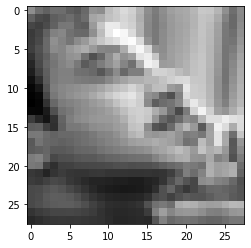

In [54]:
# peek image 
idx = 3
from matplotlib.pyplot import imshow
imshow(train_data[idx][0].reshape([28,28]), cmap = 'gray')
print(train_data[idx][0][0][0])

In [31]:
# dataloader
import torch.utils.data
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False,drop_last = True, num_workers=4)

## GAN 설계하기

교재에서 keras로 구현한 모델 정의를 읽으면서 동일한 구조를 짰음.


- 교재 GAN specification
 - ```python 
          gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        ) 
     ```
- Keras 참고자료
 - [교재 GAN.py](https://github.com/rickiepark/GDL_code/blob/master/models/GAN.py)
 - [교재 gan_camel_train.ipynb](https://nbviewer.jupyter.org/github/rickiepark/GDL_code/blob/master/04_01_gan_camel_train.ipynb)

- 신규 함수
 - [nn.UpsamplingBilinear2d](https://pytorch.org/docs/master/generated/torch.nn.UpsamplingBilinear2d.html)

In [32]:
import torch.nn as nn

in_size = 784
in_dim = 1
latent_size = 100


class GAN(nn.Module):
  def __init__(self):
    super(GAN, self).__init__()
    self.discriminator = nn.Sequential(
        # D1
        nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2), # 1(28,28) -> 64(14,14)
        nn.ReLU(),
        nn.Dropout(p=0.4),
        
        # D2
        nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2), # 64(14, 14) -> 64(7, 7)
        nn.ReLU(),
        nn.Dropout(p=0.4),

        # D3
        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2), # 64(7, 7) ->128(4, 4)
        nn.ReLU(),
        nn.Dropout(p=0.4),

        # D4
        nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2), # 128(4,4) -> 128(4, 4)
        nn.ReLU(),
        nn.Dropout(p=0.4),

        # D-end
        nn.Flatten(), # 128*4*4 = 2048
        nn.Linear(2048, 1), # 2048 -> 1
        nn.Sigmoid() # 0에서 1 사이 값 하나.
    )
    self.generator_front = nn.Sequential(
        # input size = (100)
        nn.Linear(100, 3136),
        nn.BatchNorm1d(3136),
        nn.ReLU()
    )
    self.generator_rear = nn.Sequential(
        # G1
        nn.UpsamplingBilinear2d([14, 14]),
        nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # G2
        nn.UpsamplingBilinear2d(28),
        nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        #G3
        nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1, padding=2), #64(28, 28)
        nn.BatchNorm2d(64),
        nn.ReLU(),

        #G-end
        nn.ConvTranspose2d(64, 1, kernel_size=5, padding=2), # 1(28, 28)
        nn.Tanh()
    )
  def discrim(self, x):
    h = self.discriminator(x)
    return h

  def gener(self, z):
    out = self.generator_front(z)
    out = out.reshape(out.size(0), 64, 7, 7)
    out = self.generator_rear(out)
    return out

In [33]:
test_model = GAN().to(device)

* 판별자 출력 확인 : 
torch.Size([10, 1])
tensor([[0.5028],
        [0.5034],
        [0.5035],
        [0.5008],
        [0.5059],
        [0.5006],
        [0.4995],
        [0.5083],
        [0.5057],
        [0.5032]], device='cuda:0', grad_fn=<SigmoidBackward>)

* 생성자 출력 확인 : 
torch.Size([64, 1, 28, 28])
tensor([0.9280, 0.9986, 0.9910, 0.9948, 0.9962, 0.9997, 1.0000, 1.0000, 1.0000,
        0.9999, 0.9991, 0.9965, 0.9982, 0.9972, 0.9959, 0.9972, 0.9989, 0.9989,
        0.9962, 0.9985, 0.9997, 0.9997, 0.9995, 0.9956, 0.6990, 0.9850, 0.9968,
        0.9121], device='cuda:0', grad_fn=<SelectBackward>)


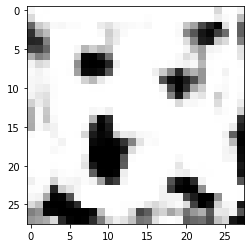

In [34]:
# 판별자 테스트
test_input = (torch.rand(10, 1, 28, 28)).to(device)
out = test_model.discrim(test_input)
print('* 판별자 출력 확인 : ')
print(out.shape)
print(out)
print()
# 생성자 테스트
test_z = (torch.rand(64, 100)).to(device)
out2 = test_model.gener(test_z)
print('* 생성자 출력 확인 : ')
print(out2.shape)
print(out2[0][0][0])
printable = out2.cpu().detach().numpy()
imshow(printable[0][0], cmap='gray')

## Training

1. 모델 선언
2. optimizer 설정
3. training 과정


- 교재 모델의 설정대로 하고 있음.
 - loss function: BCE loss
 - optimizer: RMS prop
- 참고자료
 - [GAN pytorch tutorial](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py)


In [35]:
# model 선언
model = GAN().to(device)

In [36]:
# optimizer
dis_optimizer = torch.optim.RMSprop(model.parameters(), lr = discriminator_learning_rate)  # 0.0008
gen_optimizer = torch.optim.RMSprop(model.parameters(), lr = generator_learning_rate)      # 0.0004

In [37]:
# loss function
criterion = nn.BCELoss()

In [42]:
print('Training epochs: '+ str(epochs))

data_len = len(train_loader)

for epoch in range(epochs):
  for idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)

    # make labels
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels =  torch.zeros(batch_size, 1).to(device)

    ### ======== train discriminator ========

    '''실제 사진을 real로 인식하도록 loss 계산'''
    output = model.discrim(images)
    d_real_loss = criterion(output, real_labels)
    real_score = output

    '''가짜 사진을 fake로 인식하도록 loss 계산'''
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = model.gener(z)
    output = model.discrim(fake_images)
    d_fake_loss = criterion(output, fake_labels)
    fake_score = output

    ''' Gradient 계산, Back Propagation'''
    d_loss = d_real_loss + d_fake_loss

    dis_optimizer.zero_grad()
    d_loss.backward()
    dis_optimizer.step()

    ### ======== train generator ========
    ''' 가짜 이미지 생성, 평가 '''
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = model.gener(z)
    output = model.discrim(fake_images)

    g_loss = criterion(output, real_labels)

    ''' Gradient 계산, Back Propagation '''
    gen_optimizer.zero_grad()
    g_loss.backward()
    dis_optimizer.step()

  print('Epoch[{}/{}] 판별자 Loss: {}, 생성자 Loss: {}'.format(epoch+1, epochs, d_loss.item(), g_loss.item()))

print('훈련 끗~~!')


Training epochs: 400
Epoch[1/400] 판별자 Loss: 0.6994189620018005, 생성자 Loss: 0.6875793933868408
Epoch[2/400] 판별자 Loss: 0.6984118223190308, 생성자 Loss: 0.6884045600891113
Epoch[3/400] 판별자 Loss: 0.6976439356803894, 생성자 Loss: 0.6892381906509399
Epoch[4/400] 판별자 Loss: 0.696976363658905, 생성자 Loss: 0.6898528337478638
Epoch[5/400] 판별자 Loss: 0.6965435147285461, 생성자 Loss: 0.6901949644088745
Epoch[6/400] 판별자 Loss: 0.6962878108024597, 생성자 Loss: 0.6904232501983643
Epoch[7/400] 판별자 Loss: 0.6961585283279419, 생성자 Loss: 0.6905497908592224
Epoch[8/400] 판별자 Loss: 0.6959100961685181, 생성자 Loss: 0.6909597516059875
Epoch[9/400] 판별자 Loss: 0.6956490874290466, 생성자 Loss: 0.6910516619682312
Epoch[10/400] 판별자 Loss: 0.6955385208129883, 생성자 Loss: 0.6911613345146179
Epoch[11/400] 판별자 Loss: 0.6954337358474731, 생성자 Loss: 0.6912658214569092
Epoch[12/400] 판별자 Loss: 0.6953331232070923, 생성자 Loss: 0.6913660168647766
Epoch[13/400] 판별자 Loss: 0.6952404975891113, 생성자 Loss: 0.6914796829223633
Epoch[14/400] 판별자 Loss: 0.69514667987823

KeyboardInterrupt: ignored

## 생성 이미지 확인

1. 랜덤 생성
2. 가장 가까운 이미지와 비교하기

[-1.         -1.         -1.         -1.         -1.         -0.9999999
 -0.99999934 -0.99999946 -0.9999999  -0.99999994 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.99999994 -0.99999994 -0.99999994 -1.         -1.         -1.
 -1.         -1.         -1.         -0.99998754]


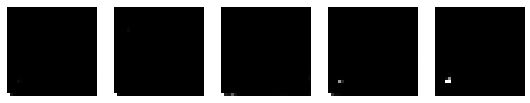

In [48]:
import matplotlib.pyplot as plt

z = torch.randn(10, 100).to(device)
image = model.gener(z)

column, row = 8, 2
fig = plt.figure(figsize = (15,5))

for i in range(1, 6):

  show = image[i].cpu().detach().numpy()
  
  sub = fig.add_subplot(row, column, i)
  sub.axis('off')        
  sub.imshow(show[0])
  sub.imshow(show[0], cmap='gray')

print(show[0][0])